In [0]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib

In [0]:
#帶入資料， 分成test&train
fashion_mnist = keras.datasets.fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

In [4]:
#看圖片shape
train_images.shape

(60000, 28, 28)

In [0]:
#畫圖
c = random.randint(0, 59999)
#去掉刻度表
plt.axis("off")
print(train_labels[c])
plt.imshow(train_images[c], cmap="gray")

In [0]:
#y是什麼東西
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
              'Sandal', 'Shirt', 'Sneaker','Bag', 'Ankle boot']
# class_names = ['短袖圓領T恤', '褲子', '套衫', '連衣裙', '外套',
#               '涼鞋', '襯衫', '運動鞋','包', '短靴']
# zhfont = matplotlib.font_manager.FontProperties(fname='./fashion_mnist_data/SimHei-windows.ttf')

In [0]:
#畫圖
plt.figure(figsize=(14,6))
width = 10
height = int(len(train_images[0:35]) / width)+1

for i, img in enumerate(train_images[0:35]):
    #(height, width, 圖片位置)
    plt.subplot(height, width, i + 1)
    msg = class_names[train_labels[i]]
    plt.title(msg)
    #可以設置中文，但目前是colab所以無法用
    #plt.xlabel(msg, fontproperties = zhfont)
    #不显示坐标尺寸
    plt.axis("off")
    plt.imshow(img, cmap="gray")

In [0]:
#先把圖片平攤成1維且標準化（0~1）， 把y one hot

from keras.utils.np_utils import to_categorical
# 對圖片做出預處理: 攤平(1D) -> 0~1 #攤平變成1維, 變成0~1 (0~1 根據工具不同)
x_train_shape = train_images.reshape(60000, 784) / 255
x_test_shape = test_images.reshape(10000, 784) / 255
# 對答案做出預處理: One-Hot
y_train_cat = to_categorical(train_labels)
y_test_cat = to_categorical(test_labels)
y_train_cat[0]

In [59]:
# 設置mlp

from keras.models import Sequential
# Dense: 全連接層
from keras.layers import Dense
mlp = Sequential()
#0=黑 255=白 所以是256個 ,圖片格式 （input_dim）= 28*28=784
# 一層隱藏層的模型，第一個隱藏層記得要寫出特徵的數目: input_dim
mlp.add(Dense(256, activation="relu", input_dim=784))
#多一個是bias = 平均數, 梯度下降的方法, 取及格分數,來把判斷式移到0點, 直接取0以上
#一個神經元 一個activation 一個bias,所以Dense 10個=Param多了10
#Param=784*256+256 +256=bias,一個filter一個bias 
#mlp.add(Dense(128, activation="relu"))
mlp.add(Dense(10, activation="softmax"))
mlp.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 256)               200960    
_________________________________________________________________
dense_12 (Dense)             (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


In [0]:
# 把 MLP compile

# 多個softmax loss= categorical_crossentropy 
# 單個 sigmid  loss= binary_crossentropy 
# loss: 如何來衡量你的模型預測的多準
# optimizer: 梯度下降過程該如何更好更快,adam優化梯度下降
# metrics: 你還需要度量標準
mlp.compile(loss="categorical_crossentropy",
            optimizer="adam",
            metrics=["accuracy"])

In [0]:
# 訓練模型，看看迭代次數跟準確率如何

# batch_size: 問幾個人才調整方向(梯度下降)
# epochs: 整份資料集該翻幾遍才到最好
# validation_split: 留多少%下來考試
# 一個epoch多少次調整(梯度下降): 54000(60000 - 6000) / 200 -> 270梯度下降
# verbose: 要印多少log (0: 最多(進度條), 1:完全沒有, 2:必要的就好)
train_history =mlp.fit(x_train_shape, y_train_cat,
        batch_size=200, 
        epochs=10,
        validation_split=0.1,
        verbose=2)

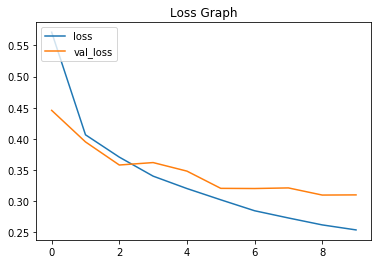

In [62]:
#檢查overfitting
plt.plot(train_history.history["loss"])
plt.plot(train_history.history["val_loss"])
plt.title("Loss Graph")
plt.legend(['loss', 'val_loss'], loc="upper left")

In [58]:
#多加一層128的 反而比較差
mlp.evaluate(x_test_shape, y_test_cat)

10000/10000 [==============================] - 0s 37us/step


[0.3449440915822983, 0.8787]

In [63]:
#預測的結果
mlp.evaluate(x_test_shape, y_test_cat)

10000/10000 [==============================] - 0s 36us/step


[0.32527207087278365, 0.8825]

In [0]:
# 混淆矩陣,來看有哪些走鐘了
from sklearn.metrics import confusion_matrix
import pandas as pd
pre = mlp.predict_classes(x_test_shape)
pd.DataFrame(confusion_matrix(test_labels, pre))

In [0]:
# 把走鐘的就揪出來

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
pre = mlp.predict_classes(x_test_shape)
# np.nonzero取出矩陣中的非零元素的座標 ,pre != y_test 出來是true false (1，0)
idx = np.nonzero(pre != test_labels)[0]
# 預測錯誤的正確標籤
false_ori_label = test_labels[idx]
# 預測錯誤的預測標籤
false_pre_label = pre[idx]
# 預測錯誤的圖片本身
false_img = test_images[idx]

In [78]:
#預測錯的筆數
len(false_ori_label)

1175

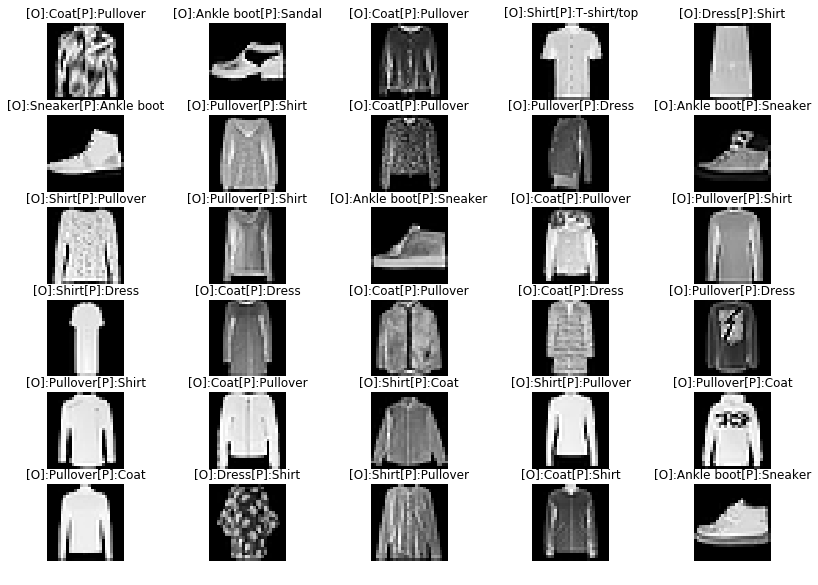

In [80]:
# 畫出30個走鐘的圖

#figsize:指定figure的宽和高，单位为英寸
plt.figure(figsize=(14, 400))
width = 5
height = int(len(false_img) / width) + 1

for i, img in enumerate(false_img[0:30]):
    #(height, width, 圖片位置)
    plt.subplot(height, width, i + 1)
    msg = "[O]:" + str(class_names[false_ori_label[i]]) + "[P]:" + str(class_names[false_pre_label[i]])
    plt.title(msg)
    #不显示坐标尺寸
    plt.axis("off")
    plt.imshow(img, cmap="gray")
    
#y是什麼東西
#class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
#              'Sandal', 'Shirt', 'Sneaker','Bag', 'Ankle boot']
# class_names = ['短袖圓領T恤', '褲子', '套衫', '連衣裙', '外套',
#               '涼鞋', '襯衫', '運動鞋','包', '短靴']